<a href="https://colab.research.google.com/github/guilimadev/Volleyball-Game-Win-Predictor/blob/main/Volleyball_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import warnings

warnings.filterwarnings("ignore")

In [48]:
df_vnl = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/vnl_2021_preliminaryround_mens.csv',index_col=1)
df_vnl = df_vnl.drop('Unnamed: 0', axis=1)

In [49]:
df_vnl.index.names = ['id_jogo']


In [50]:
df_vnl = df_vnl.rename(columns={'qts sets': 'qtd sets'})
df_vnl.head()

,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
11700,France,77,39,8,51,44,7,19,Bulgaria,76,36,15,47,39,5,17,3,True
11701,Germany,70,42,6,60,35,5,19,Australia,61,28,9,46,25,3,15,3,True
11702,Japan,94,45,13,48,50,7,7,Iran,84,41,12,49,46,8,16,3,True
11703,Serbia,121,66,19,55,33,14,19,Slovenia,111,53,21,48,30,9,17,4,True
11704,Netherlands,89,49,14,55,20,6,18,Russia,94,51,11,54,29,10,18,4,False


In [51]:
df_sla = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/Superliga_2021.csv', index_col=0)
df_sla.head()


,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
1239,MONTES CLAROS AMERICA VOLEI,102,41,9,40,59,14,14,BRASILIA VÔLEI,101,39,13,39,76,14,16,4,True
1240,VOLEI FUNVIC NATAL,59,33,6,56,59,11,13,GOIÁS VÔLEI,61,18,13,30,48,6,8,3,True
1241,VOLEI RENATA,123,57,11,46,64,15,21,SESI-SP,138,58,12,42,66,13,18,5,False
1242,VEDACIT VÔLEI GUARULHOS,102,54,16,53,53,7,17,FIAT/GERDAU/MINAS,103,54,10,52,59,7,14,4,False
1243,SADA CRUZEIRO,76,42,5,55,52,5,12,FARMA CONDE VÔLEI - SÃO JOSÉ,82,39,7,48,49,4,13,3,True


In [52]:
df_merged = pd.concat([df_vnl, df_sla])


In [53]:
df_merged['qtd sets'].describe

<bound method NDFrame.describe of id_jogo
11700    3
11701    3
11702    3
11703    4
11704    4
        ..
1305     3
1306     4
1307     3
1308     3
1309     3
Name: qtd sets, Length: 185, dtype: int64>

In [54]:
df_merged.shape

(185, 18)

In [55]:
df_merged['total atq home'] = df_merged['total atq home'] / df_merged['qtd sets']
df_merged['pontos ataques home'] = df_merged['pontos ataques home'] / df_merged['qtd sets']
df_merged['atq error home'] = df_merged['atq error home'] / df_merged['qtd sets']
df_merged['bloqueio home'] = df_merged['bloqueio home'] / df_merged['qtd sets']
df_merged['server error home'] = df_merged['server error home'] / df_merged['qtd sets']
df_merged['total atq away'] = df_merged['total atq away'] / df_merged['qtd sets']
df_merged['pontos ataques away'] = df_merged['pontos ataques away'] / df_merged['qtd sets']
df_merged['atq error away'] = df_merged['atq error away'] / df_merged['qtd sets']
df_merged['bloqueio away'] = df_merged['bloqueio away'] / df_merged['qtd sets']
df_merged['server error away'] = df_merged['server error away'] / df_merged['qtd sets']

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn import metrics
X = df_merged.drop(columns=['team home', 'team away', 'vencedor', 'qtd sets'])
y = df_merged['vencedor']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = RandomForestClassifier(min_samples_leaf=5, min_samples_split=2,n_estimators=100)
model.fit(X_train, y_train)
estimator = model.estimators_[5]


y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=2)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Score: " , scores.mean())


Accuracy: 0.9107142857142857
Score:  0.8863370733987845


In [254]:
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,                
                rounded = True, proportion = False, 
                precision = 2, filled = True)

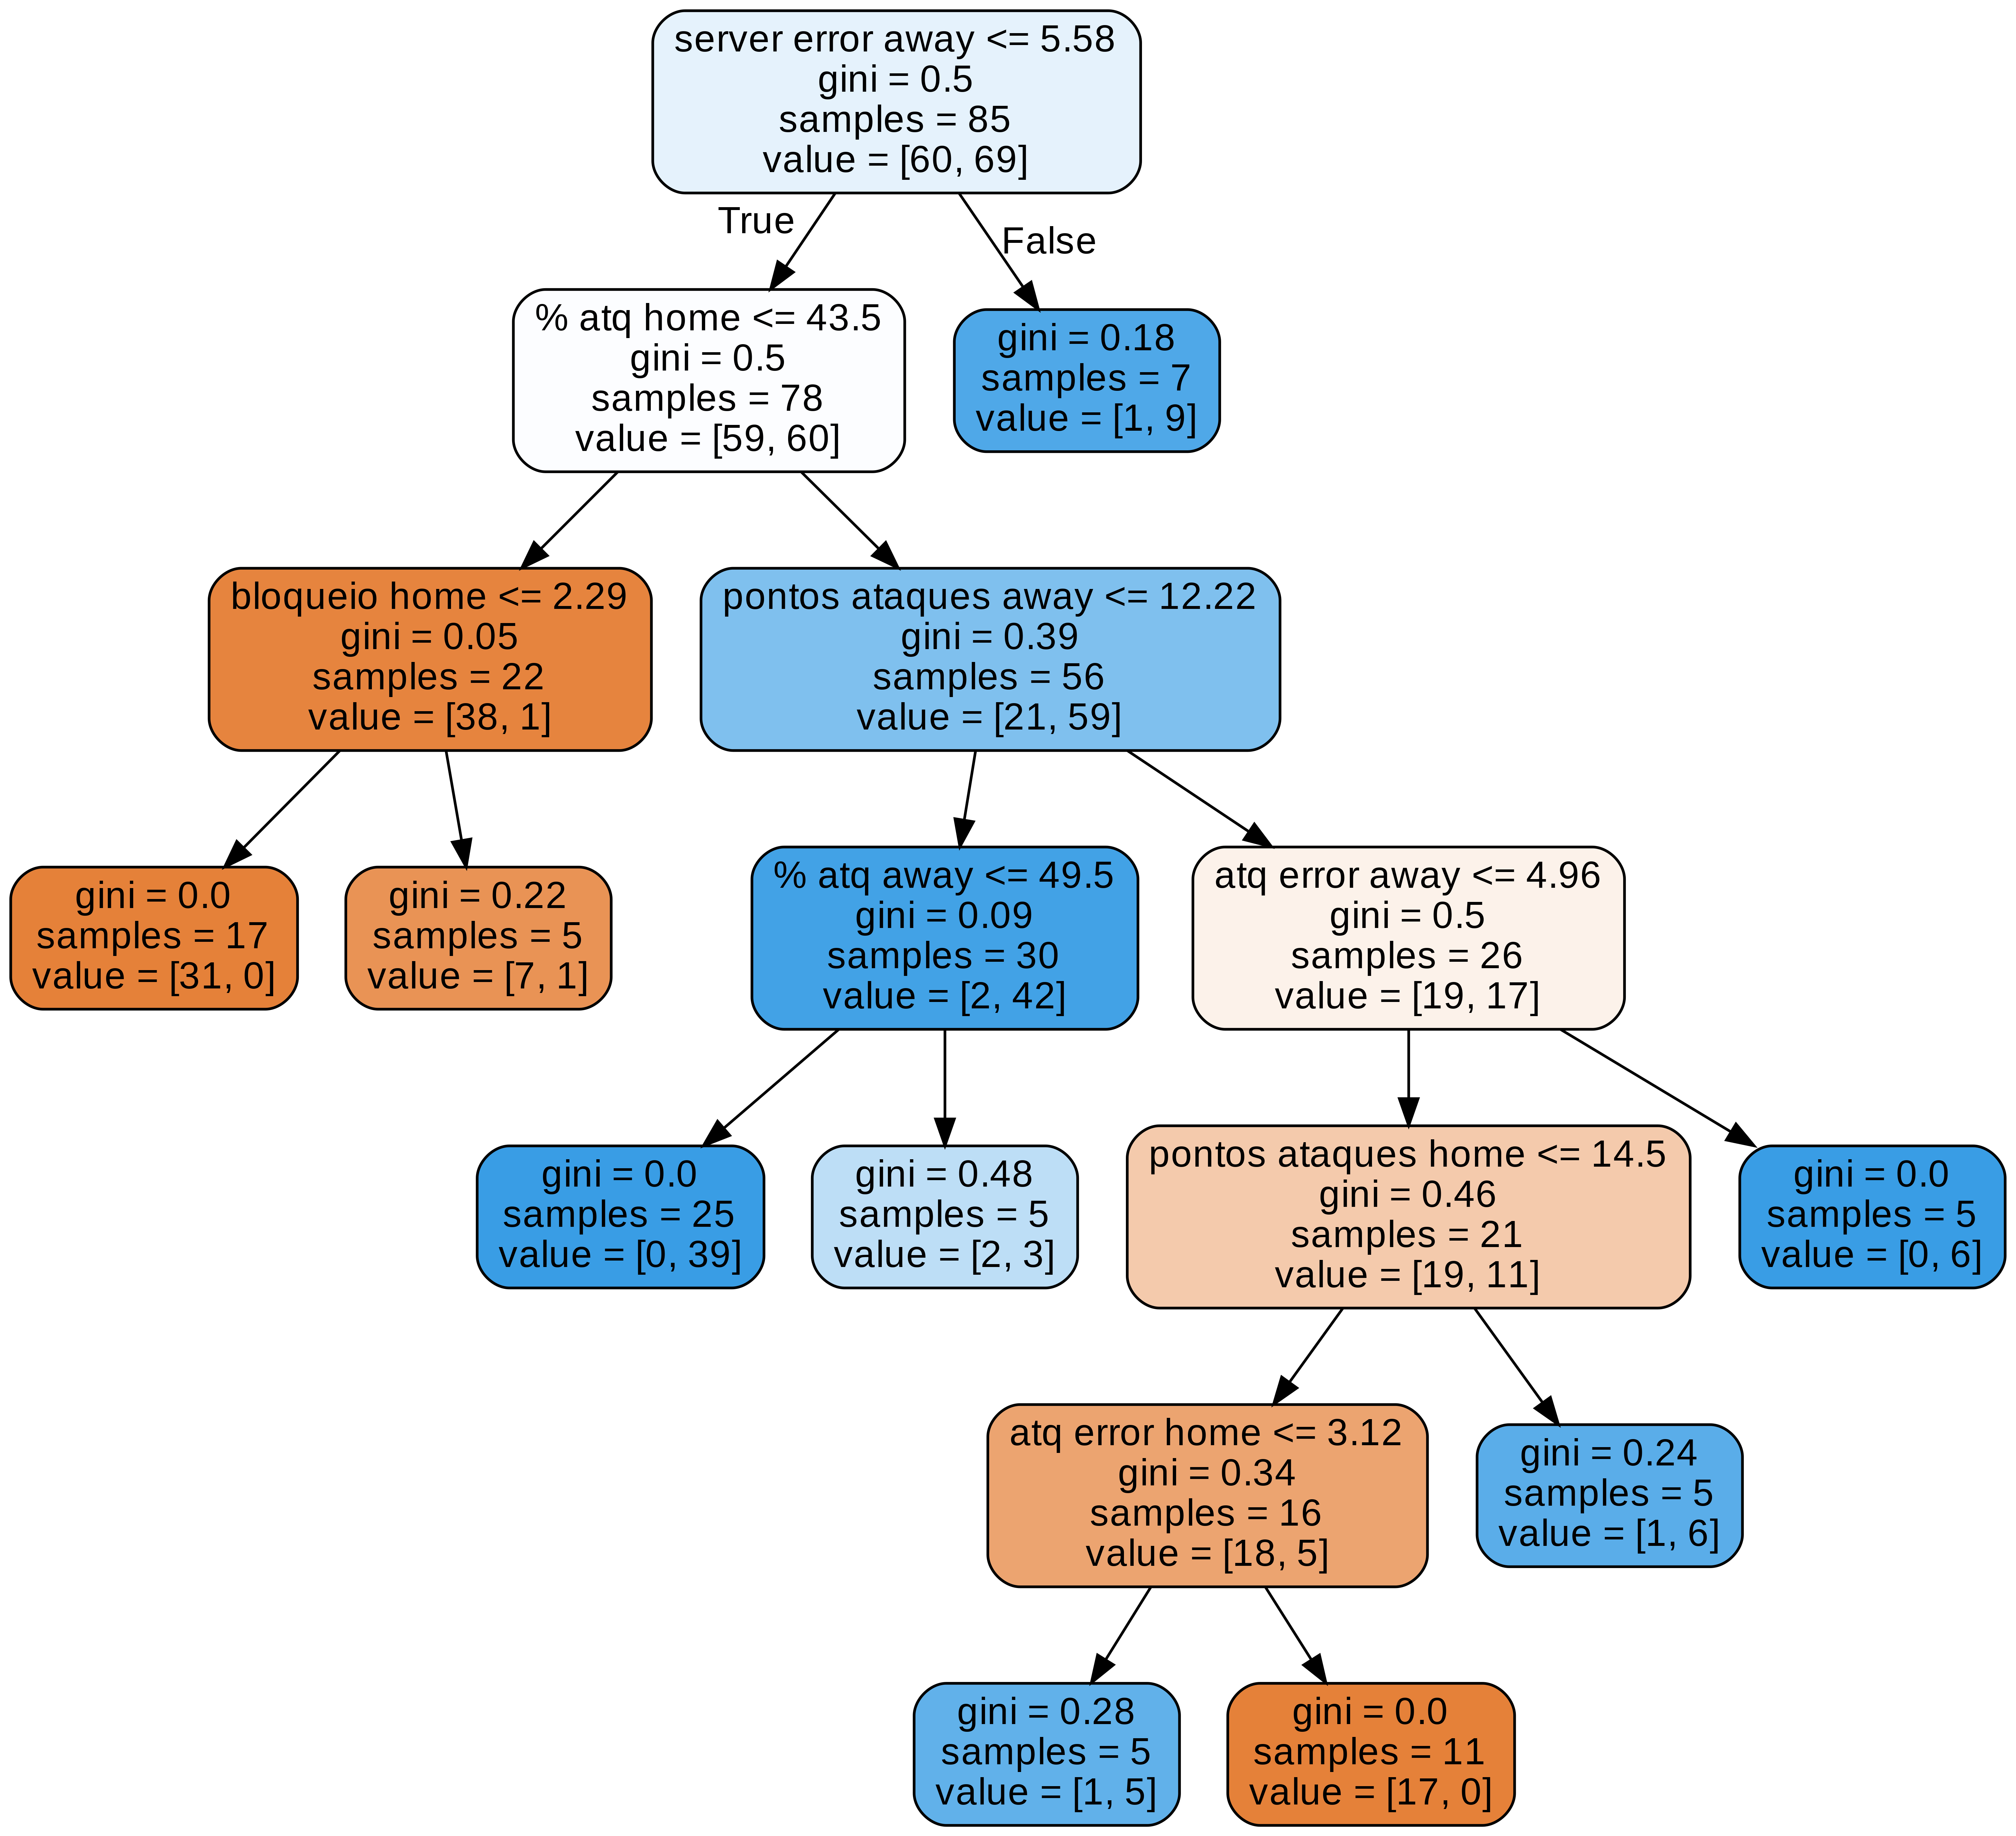

In [255]:
from subprocess import call
from IPython.display import Image
call(['dot','-Tpng','tree.dot','-o','tree.png','-Gdpi=600'])
Image(filename='tree.png')

In [256]:
df_merged.head()
df_splitted_away = df_merged[['team away','total atq away','pontos ataques away','atq error away','% atq away','% rec away','bloqueio away','server error away','vencedor']]
cols = ['team', 'total atq', 'pontos ataque', 'atq error', '% atq', '% rec', 'bloqueio', 'server error','vencedor']
df_splitted_away.columns = cols
df_splitted2 = df_merged[['team home','total atq home','pontos ataques home','atq error home','% atq home','% rec home','bloqueio home','server error home','vencedor']]
df_splitted2.columns = cols
df_splitted2.head()

,team,total atq,pontos ataque,atq error,% atq,% rec,bloqueio,server error,vencedor
id_jogo,,,,,,,,,
11700,France,25.666667,13.00,2.666667,51,44,2.333333,6.333333,True
11701,Germany,23.333333,14.00,2.000000,60,35,1.666667,6.333333,True
11702,Japan,31.333333,15.00,4.333333,48,50,2.333333,2.333333,True
11703,Serbia,30.250000,16.50,4.750000,55,33,3.500000,4.750000,True
11704,Netherlands,22.250000,12.25,3.500000,55,20,1.500000,4.500000,False


In [257]:
df_splitted_away['vencedor'] = ~df_splitted_away['vencedor']


In [258]:
df_splitted_away.tail()

,team,total atq,pontos ataque,atq error,% atq,% rec,bloqueio,server error,vencedor
id_jogo,,,,,,,,,
1305,AZULIM/GABARITO/UBERLANDIA,24.666667,12.000000,3.333333,49,56,0.666667,3.333333,False
1306,VOLEI RENATA,19.750000,12.250000,2.500000,62,66,1.750000,3.250000,True
1307,APAN/ELEVA,23.333333,9.000000,1.666667,39,53,1.000000,4.333333,False
1308,MONTES CLAROS AMERICA VOLEI,24.666667,13.666667,2.666667,55,73,2.333333,3.000000,True
1309,VEDACIT VÔLEI GUARULHOS,22.333333,9.333333,3.333333,42,44,2.000000,3.333333,False


In [259]:
frames = [df_splitted_away, df_splitted2]
df_merged2 = pd.concat(frames)

df_merged2[['team']]

,team
id_jogo,
11700,Bulgaria
11701,Australia
11702,Iran
11703,Slovenia
11704,Russia
...,...
1305,GOIÁS VÔLEI
1306,BRASILIA VÔLEI
1307,FIAT/GERDAU/MINAS


In [260]:
teste = df_merged2.loc[df_merged2['team'] == 'AZULIM/GABARITO/UBERLANDIA']
teste.mean()

total atq        24.939394
pontos ataque    10.583333
atq error         2.765152
% atq            42.636364
% rec            57.000000
bloqueio          1.893939
server error      3.651515
vencedor          0.000000
dtype: float64

In [261]:
teste2 = df_merged2.loc[df_merged2['team'] == 'APAN/ELEVA']
teste2.mean()

total atq        25.431818
pontos ataque    12.401515
atq error         2.378788
% atq            49.090909
% rec            63.545455
bloqueio          2.424242
server error      4.318182
vencedor          0.545455
dtype: float64

In [262]:
teams = df_merged2.team.unique()

In [263]:
import ipywidgets as widgets
from ipywidgets import interact

a = widgets.Dropdown(
    options=teams,  
    description='Home:',
    disabled=False,
)

b = widgets.Dropdown(
    options=teams,    
    description='Away:',
    disabled=False,
)



In [264]:
model.classes_

array([False,  True])

In [267]:
def resultPredict(a,b):
  home = df_merged2.loc[df_merged2['team'] == a]
  away = df_merged2.loc[df_merged2['team'] == b]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')

In [268]:
interact(resultPredict,a=teams,b=teams)

interactive(children=(Dropdown(description='a', options=('Bulgaria', 'Australia', 'Iran', 'Slovenia', 'Russia'…

<function __main__.resultPredict>